In [1]:
#analysis boilerplate imports
import fnal_column_analysis_tools
from fnal_column_analysis_tools.lookup_tools import extractor,evaluator
from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray
from fnal_column_analysis_tools.striped import PhysicalColumnGroup,ColumnGroup,jaggedFromColumnGroup

import numpy as np
from awkward import JaggedArray,Table
import uproot
import time

In [2]:
#histogram display boilerplate
from histbook import Hist, beside, groupby, below
from histbook import bin as hbin
from collections import OrderedDict
from striped.job import SinglePointStripedSession as Session, IPythonDisplay
import histbook as hb
import math

all_hists = OrderedDict()
cat = hb.groupby("category", keeporder=True)

def add_1d(*args):
    h = hb.Hist(hb.bin(*args), cat)
    all_hists[args[0]] = h
    return h

display_opts = {'width': 200, 'height': 200}
def buildDisplay(hists, cols=3):
    rows = []
    for iRow in range(int(math.ceil(len(hists)/cols))+1):
        hrowname = hists.keys()[iRow*cols:(iRow+1)*cols]
        hrow = hists.values()[iRow*cols:(iRow+1)*cols]
        rows.append(hb.beside(*tuple(h.overlay("category").step(n, **display_opts) for h,n in zip(hrow, hrowname))))
    return IPythonDisplay(
        hb.below(*tuple(rows))
    )

In [3]:
#make and fill a histogram of the masses
add_1d("m_J", 150,50,200)#, weight="weight")
add_1d("pT_J", 300,200,800)#, weight="weight")
add_1d("deepDoubleB",50,0,1)
add_1d("tau21",50,0,1)
add_1d("tau32",50,0,1)

display = buildDisplay(all_hists,cols=3)

In [4]:
extract = extractor()
correction_data = open("dazsle_corr_files.txt").readlines()
extract.add_weight_sets(correction_data)
extract.finalize()
#define the weights we want to keep
keep_weights = ["Rho2D","ZJetsNLO","WJetsNLO",
                "PUWeight2016_central","PUWeight2016_up","PUWeight2016_down",
                "PUWeight2017_central","PUWeight2017_up","PUWeight2017_down",
                "data_obs_muCR4_denominator","data_obs_muCR4_numerator",
                "Mu50_PtEtaBins/efficienciesDATA/pt_abseta_DATA",
                "NUM_SoftID_DEN_genTracks/abseta_pt_value","NUM_SoftID_DEN_genTracks/abseta_pt_error",
                "NUM_LooseRelIso_DEN_LooseID/abseta_pt_value","NUM_LooseRelIso_DEN_LooseID/abseta_pt_error"]
#make the evaluator
evaluate = extract.make_evaluator(reduce_list=keep_weights)

In [5]:
#build a string of "OR" for list of triggers from json bits file
import json
def selectTriggers(imap,triggerMap):
    if not imap =={}:
        version     = imap['version']
        hltNames    = imap['names']
        branchName  = imap['branchName'] #triggerBits or moreTriggerBits
        #validate input
        if version in triggerMap:
            NameToBitMap = triggerMap[version]
        else:
            print "ERROR! Cannot find triggerbit map of the requested bit version =%s. Possible versions are: %s"%(version, ",".join(triggerMap.keys()))
        tCuts = []
        for hltName in hltNames:
            print hltName
            if hltName in NameToBitMap:
                bitValue = int(2**float(NameToBitMap[hltName]))
                tCuts.append("%s & %s"%(branchName,bitValue))
            else:
                print "ERROR! Cannot find the TriggerBit for %s"%hltName 
        print "Using trigger bits = ","||".join(tCuts) 
        return "||".join(tCuts) 
    else:
        return "1"

triggerBitMaps = json.load(open("ggH/TriggerBitMap.json"))

triggerNames = {} #???
triggerCut = selectTriggers(triggerNames,triggerBitMaps)
if not triggerNames=={}:
    print "List of OR Triggers : ",triggerNames['names']
    print "Using trigger cuts  : ",triggerCut

In [6]:
#trigger eff scale factors (todo: )
def VtrigSF(ak8msd,ak8pt):
    msd = ak8msd
    pt = ak8pt
    if isinstance(ak8msd,JaggedArray):
        assert (ak8msd.offsets==ak8pt.offsets).all()
        msd = ak8msd.flatten()
        pt = ak8pt.flatten()
    else:
        assert ak8msd.size == ak8pt.size
    msd = np.clip(msd,0,300)
    pt = np.clip(pt,200,1000)
    trig_num = evaluate['data_obs_muCR4_numerator'](msd,pt)
    trig_den = evaluate['data_obs_muCR4_denominator'](msd,pt)
    eff = trig_num/trig_den
    if isinstance(ak8msd,JaggedArray):
        eff = JaggedArray.fromoffsets(ak8pt.offsets,eff)
    return eff

In [7]:
#WJetsQQ and ZJetsQQ kfactors
def VJetsQQ_kFactor(sampleName,lookup,genVPt):
    kfactor = genVPt.ones_like()
    if 'ZJetsToQQ_' in sampleName:
        kfactor = lookup['ZJetsNLO'](np.clip(genVPt,250.,1200.))
    elif 'WJetsToQQ_' in sampleName:
        kfactor = lookup['WJetsNLO'](np.clip(genVPt,250.,1200.))
    return kfactor

In [8]:
#PUPPI soft-drop mass correction
def corrGEN(pt):
    #self.corrGEN = ROOT.TF1("corrGEN", "[0]+[1]*pow(x*[2],-[3])", 200, 3500)
    #self.corrGEN.SetParameter(0, 1.00626)
    #self.corrGEN.SetParameter(1, -1.06161)
    #self.corrGEN.SetParameter(2, 0.0799900)
    #self.corrGEN.SetParameter(3, 1.20454)
    x = np.clip(pt,200,3500)
    return 1.00626 - 1.06161*pow(x*0.0799900,-1.20454)

def corrRECO_cen(pt):    
    x = np.clip(pt,200,3500)
    return 1.09302 + x*(-0.000150068+x*(3.44866e-07+x*(-2.68100e-10+x*(8.67440e-14+ x*(-1.00114e-17)))))

def corrRECO_for(pt):  
    x = np.clip(pt,200,3500)
    return 1.27212 + x*(-0.000571640+x*(8.37289e-07+x*(-5.20433e-10+x*(1.45375e-13+ x*(-1.50389e-17)))))

def PUPPIweight(ak8pt,ak8eta):
    pt = ak8pt
    eta = ak8eta
    if isinstance(ak8pt,JaggedArray):
        assert (ak8pt.offsets==ak8eta.offsets).all()
        pt = ak8pt.flatten()
        eta = ak8eta.flatten()
    else:
        assert ak8pt.size == ak8eta.size
        
    genCorr = corrGEN(pt)
    recoCorr = np.ones_like(eta)
    
    etaCut = np.abs(eta) < 1.3
    recoCorr[etaCut] = corrRECO_cen(pt[etaCut])
    recoCorr[~etaCut] = corrRECO_for(pt[~etaCut])
    
    total = genCorr*recoCorr
    
    if isinstance(ak8pt,JaggedArray):
        total = JaggedArray.fromoffsets(ak8pt.offsets,total)
    
    return total

In [9]:
#analysis cut defaults
PTCUT = 450.
PTCUTMUCR = 400.
#DBTAGCUT = 0.9
#DBTAGCUT = 0.86
#DBTAGCUT = 0.94
T21DDTCUT = 0.55
MUONPTCUT = 55
METCUT = 140
MASSCUT = 40
NJETCUT = 100

#self._cutFormula = ROOT.TTreeFormula("cutFormula",
#                                     "(" + cutFormula + ")&&("+self._triggerCut+")&&(AK8Puppijet0_pt>%f||AK8Puppijet0_pt_JESDown>%f||AK8Puppijet0_pt_JESUp>%f||AK8Puppijet0_pt_JERUp>%f||AK8Puppijet0_pt_JERDown>%f)" % (
#                                     PTCUTMUCR, PTCUTMUCR, PTCUTMUCR, PTCUTMUCR, PTCUTMUCR), self._tt)

2.92147967848e-06


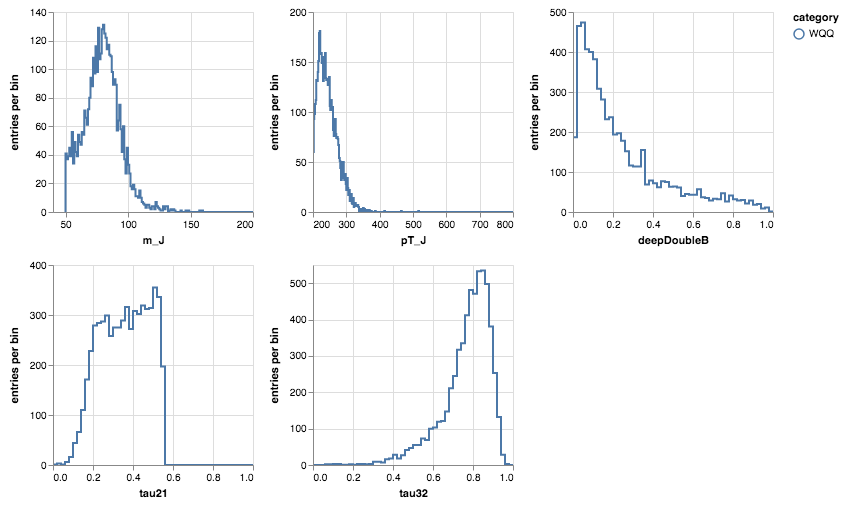

3.13290983827e-06


2.6188900166e-05


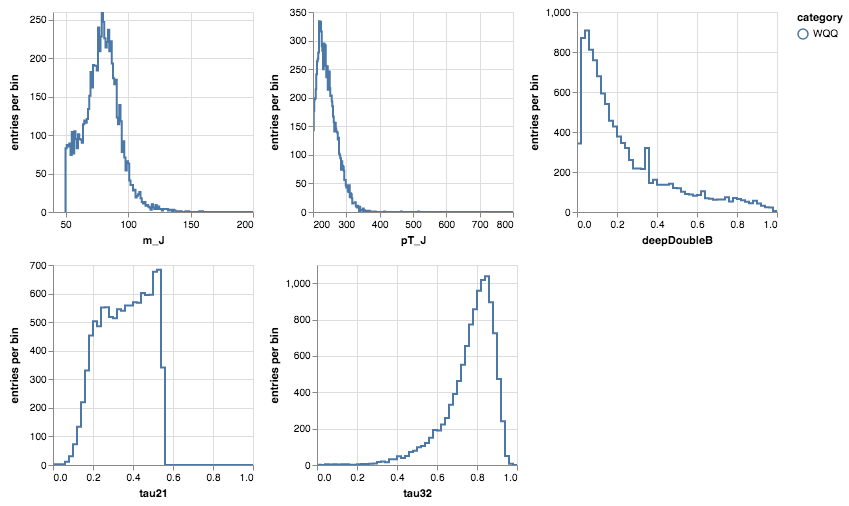

In [11]:
outer_tic = time.time()

display.init()
_ = map(lambda h: h.clear(), all_hists.values())

filestr = "/Users/lagray/coffea/bacon_prod/WJetsToQQ_HT400to600_qc19_3j_TuneCP5_13TeV/*.root"

evtColumns = {'pfmet':'pfMETC','pfmetphi':'pfMETCphi','puppet':'puppETC','puppetphi':'puppETCphi',
              'npu':'nPUmean'}

ak8columns = {'pt':'AK8Puppi.pt','eta':'AK8Puppi.eta','phi':'AK8Puppi.phi','mass':'AK8Puppi.mass',
              'deepcsvb':'AddAK8Puppi.doublecsv','msd':'AddAK8Puppi.mass_sd0','deepdoubleb':'AddAK8Puppi.deepdoubleb',
              'deepdoubleb_nomasssculptpen':'AddAK8Puppi.deepdoubleb_nomasssculptpen','tau1':'AddAK8Puppi.tau1',
              'tau2':'AddAK8Puppi.tau2','tau3':'AddAK8Puppi.tau3','e3_v2_sdb1':'AddAK8Puppi.e3_v2_sdb1',
              'e2_sdb1':'AddAK8Puppi.e2_sdb1'}

ak4columns = {'pt':'AK4Puppi.pt','eta':'AK4Puppi.eta','phi':'AK4Puppi.phi','mass':'AK4Puppi.mass',
              'qgid':'AK4Puppi.qgid','csv':'AK4Puppi.csv'}

all_columns = [evtColumns,ak8columns,ak4columns]

columns = []
for cols in all_columns: columns.extend(list(cols.values()))

tot_events = 0
for arrays in uproot.iterate(filestr,'Events',columns,entrysteps=50000):
    tic = time.time()
    #event-level info (run / evt / met / etc)
    eventInfo = JaggedArray.fromcounts(np.ones_like(arrays[evtColumns['pfmet']],dtype=np.int),
                                       Table({key:arrays[val] for key,val in evtColumns.items()}))
    
    #gen particle info (TODO)
    #genParticles = 
    #k-factors for jets
    #vjetsKF = genParticles.pt.ones_like()
    #genParticles.add_attributes(vjetsKF=vjetsKF)
    
    #setup ak4 jet candidates
    ak4puppijet = JaggedCandidateArray.candidatesfromcounts(arrays[ak4columns['pt']].counts,
                                                            **{key:arrays[val].content for key,val in ak4columns.items()})

    #setup ak8 jet candidates
    ak8puppijet = JaggedCandidateArray.candidatesfromcounts(arrays[ak8columns['pt']].counts,
                                                            **{key:arrays[val].content for key,val in ak8columns.items()})
    msd_corr_8 = ak8puppijet.msd*PUPPIweight(ak8puppijet.pt,ak8puppijet.eta)
    clamped_msd_corr_8 = np.maximum(msd_corr_8,1e-8) #need to bound corrected jet mass from below???
    #need JER/JEC uncertainties up/down added here too!!
    rh_8 = 2.0*(np.log(clamped_msd_corr_8) - np.log(ak8puppijet.pt))  # tocheck here
    rhP_8 = 2.0*np.log(clamped_msd_corr_8) - np.log(ak8puppijet.pt)
    jtau21_8 = ak8puppijet.tau2/(ak8puppijet.tau1 + 1e-8)
    jt21P_8 = jtau21_8 + 0.063 * rhP_8
    N2sdb1=ak8puppijet.e3_v2_sdb1/(ak8puppijet.e2_sdb1**2 + 1e-8)
    jtN2b1sdddt_8 = N2sdb1 - evaluate['Rho2D'](rh_8,ak8puppijet.pt)
    #trigger weights for the Vs (TODO: up and down)    
    trigweight = VtrigSF(ak8puppijet.msd,ak8puppijet.pt)
    #store all our calculated stuff
    ak8puppijet.add_attributes(msd_corr_8=msd_corr_8,
                               rh_8=rh_8,
                               rhP_8=rhP_8,
                               tau21=jtau21_8,
                               tau32=ak8puppijet.tau3/(ak8puppijet.tau2 + 1e-8),
                               jt21P_8=jt21P_8,
                               N2sdb1=N2sdb1,
                               jtN2b1sdddt_8=jtN2b1sdddt_8,
                               trigweight=trigweight)    
    
    #todo -> trigger selection
    #presel = ( (ak8puppijet.pt > PTCUTMUCR) ) # | 
    #          # AK8Puppijet0_pt_JESUp > PTCUTMUCR | 
    #          # AK8Puppijet0_pt_JESDown > PTCUTMUCR | 
    #         # AK8Puppijet0_pt_JERUp > PTCUTMURC |
    #          # AK8Puppijet0_pt_JERDown > PTCUTMURC 
    #         )
    presel = ( ( ak8puppijet.counts > 0 ) & ( ak8puppijet.tau21 < T21DDTCUT) )
    
    #single muon control regions
    #if (jpt_8 > PTCUTMUCR and jmsd_8 > MASSCUT and 
    #    nmuLoose == 1 and neleLoose == 0 and ntau == 0 and vmuoLoose0_pt > MUONPTCUT and 
    #    abs(vmuoLoose0_eta) < 2.1 and isTightVJet and abs(vmuoLoose0_phi - jphi_8) > 2. * ROOT.TMath.Pi() / 3. and 
    #    n_MdR0p8_4 >= 1):
    
    #fill histograms
    all_hists['m_J'].fill(category='WQQ',m_J=ak8puppijet[presel].msd_corr_8.max())
    all_hists['pT_J'].fill(category='WQQ',pT_J=ak8puppijet[presel].pt.max())
    all_hists['deepDoubleB'].fill(category='WQQ',deepDoubleB=ak8puppijet[presel].deepdoubleb.flatten())
    all_hists['tau21'].fill(category='WQQ',tau21=ak8puppijet[presel].tau21.flatten())
    all_hists['tau32'].fill(category='WQQ',tau32=ak8puppijet[presel].tau32.flatten())
    toc = time.time()
    
    print (toc-tic)/arrays[evtColumns['pfmet']].size
    tot_events += arrays[evtColumns['pfmet']].size
    display.update()

outer_toc = time.time()

print (outer_toc-outer_tic)/tot_events